## Task 1 Notebook for Modeling and Group Assignment

In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
import cluster_utils
import umap
import umap.plot
from joblib import Parallel, delayed

from google_drive_downloader import GoogleDriveDownloader as gdd
from bokeh.plotting import output_file, save
import hdbscan
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from kmodes.kprototypes import KPrototypes
from umap_class import * 

plt.rcParams["figure.figsize"] = (10,7)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


First lets read in the data, and filter users that have approximately three months of application access data.

In [2]:
all_filenames = [i for i in glob.glob('./data/*')]

In [3]:
def get_min_max_all_files(list_minsmaxs):
    '''For every min/max in each file stored in the list, find the min of all the mins and the max of all the maxes.
    This will be a users first applciation use date and latest application use date.'''
    
    df_minmax = pd.concat(list_minsmaxs).rename(columns={'min': 'mins',
                                            'max': 'maxes'});
    df_minmax = df_minmax.reset_index().groupby(['userid']).agg({'mins': 'min',
                                              'maxes':'max'})
    return df_minmax

In [ ]:
def get_users_min_max_date(all_files):
    '''For each user per file, the the first application use date and the last application use date. Will get each files min/max date per user first.
    Then it will get the min of all the files and the max of all the files per user. '''
    list_min_max = []
    
    # get each files min/max
    for i in trange(len(all_files)):
        df = pd.read_csv(all_files[i], parse_dates=['f0_'])
        list_min_max.append(df[['f0_', 'userid']].groupby(['userid'])['f0_'].agg(['min', 'max']))
        
    # get the min of all files, get the max of all files
    df_min_max = get_min_max_all_files(list_min_max)
    
    return df_min_max

In [ ]:
df_min_max = get_users_min_max_date(all_filenames)

In [ ]:
df_min_max

### Lets look at your date distribution
Assumption: Some users might not be on everyday. I am going to make the assumption that if a user uses an application in the first week of the month, we will consider that the beginning of the three month period. If a user uses an application in the last week of the final month, this will be considered the end of the 3 month period.

In [7]:
df_min_max.mins.min()

Timestamp('2020-09-02 00:00:00')

In [8]:
df_min_max.mins.max()

Timestamp('2020-11-30 00:00:00')

<AxesSubplot:>

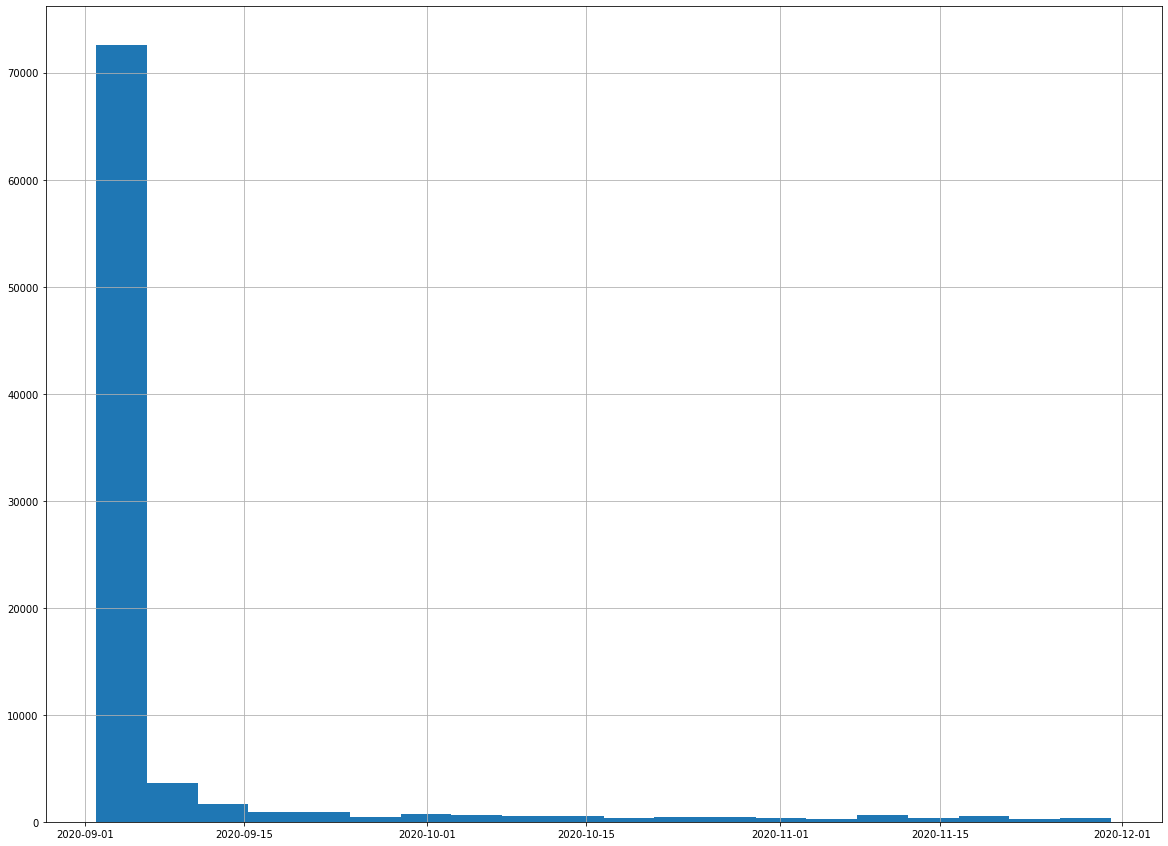

In [9]:
df_min_max.mins.hist(bins=20)

<AxesSubplot:>

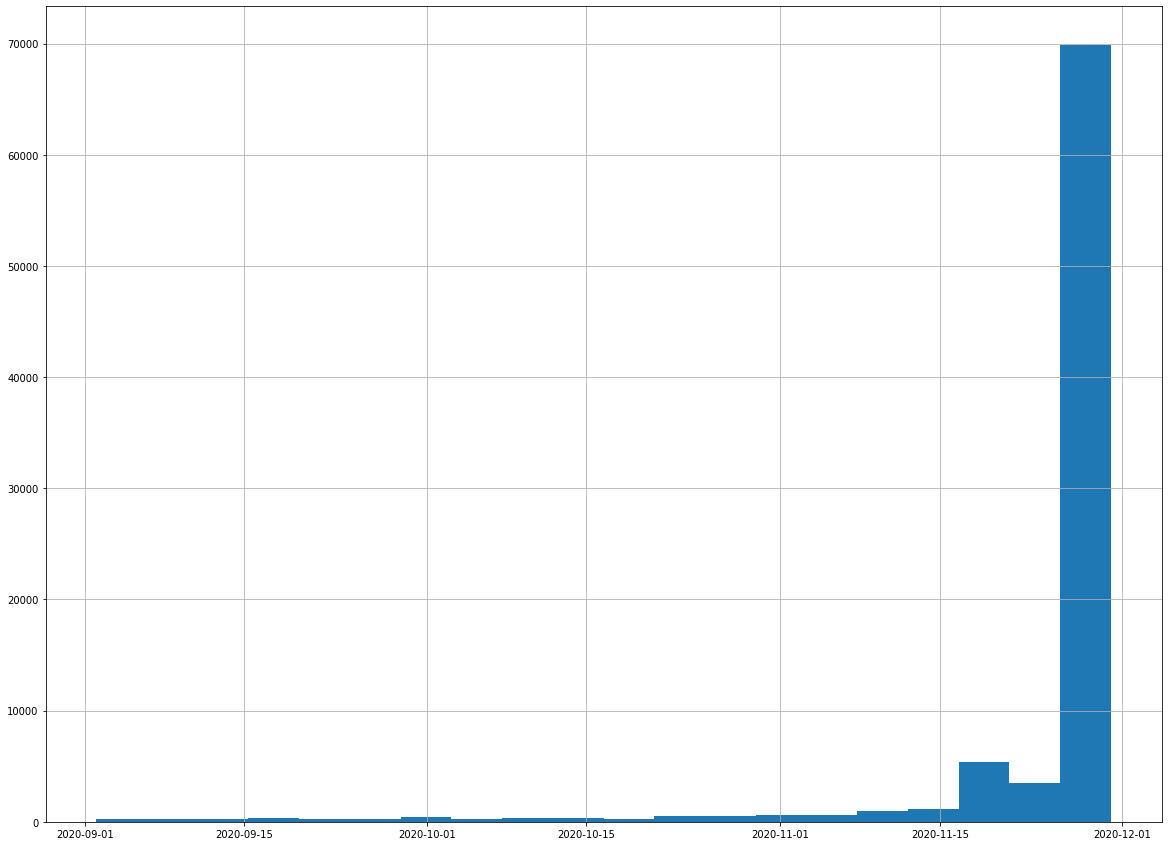

In [10]:
df_min_max.maxes.hist(bins=20)

#### Drop users without 3 months of data 
Drop Users that don't have a start date in the range of 2020-09-02 to 2020-09-09 and end date in the range 2020-11-23 to 2020-11-30

Assumption: I am considering all users that used an application in the first week, or the last week as in the range of 3 months of data.

In [11]:
df_min_max.shape

(86586, 2)

In [12]:
# We lose 19851 userid's 
cleaned_df = df_min_max[(df_min_max['mins'] <= '2020-09-09') & (df_min_max['maxes'] >= '2020-11-23')]
cleaned_df = cleaned_df.reset_index()
cleaned_df

,userid,mins,maxes
0,171,2020-09-02,2020-11-30
1,456,2020-09-02,2020-11-30
2,1508,2020-09-03,2020-11-30
3,1847,2020-09-02,2020-11-25
4,1992,2020-09-02,2020-11-27
...,...,...,...
66730,62912711,2020-09-02,2020-11-30
66731,62912713,2020-09-02,2020-11-30
66732,62912714,2020-09-02,2020-11-27
66733,62912718,2020-09-02,2020-11-30


In [13]:
df_min_max.shape[0] - cleaned_df.shape[0]

19851

### Go through each file - flatten to userid level that has 3 months of information. 
Each line will be a users unique application access history. I get this information per file. However, this users information could be spread across all 10 files, plus a user might not exist in one file, but does exist in another file. There for, I concat each of the unique application access user data per file and then sum it together to get each users complete applicaton access history over three months.

In [318]:
# read in appclass mappings and apply
app_2_class = pd.read_csv('app2appclass.csv')
app_2_class_dict = app_2_class.set_index('application')['appclass'].to_dict()

In [15]:
df_list = []
for i in trange(len(all_filenames)):
    df_segment = pd.read_csv(all_filenames[i], parse_dates=['f0_'])
    df_segment.rename(columns={"f0_": "date"}, inplace = True)
    
    # Filter users without 3 months data
    df_segment= df_segment[df_segment.userid.isin(set(cleaned_df['userid'].unique()))]
    
    # Map appclass names to applications
    df_segment['appclass'] = df_segment['application'].map(app_2_class_dict)
    
    # Aggregate each users data per file
    pivoted = pd.pivot_table(df_segment,index=['userid'], columns =['appclass'], aggfunc={'download_tx_cnt':np.sum,'upload_tx_cnt':np.sum}, fill_value = 0)
    pivoted.columns = pivoted.columns.to_flat_index()
    
    # Add new features one - per app class, how many days acccessed? Per app class, how many unique applications accessed in time window?
    new_features_df = df_segment[['application', 'userid', 'appclass']].groupby(['userid','appclass'])['application'].agg(['count', 'nunique']).reset_index().rename(columns = {'count':'days_accessed', 'nunique':'unique_applications'})
    new_features_df =pd.pivot_table(new_features_df,index=['userid'], columns =['appclass'], fill_value = 0)

    # Merge to flatten structure
    df_merged = pd.merge(pivoted, new_features_df, 'left', on = ["userid"] )
    
    # Append all user files together
    df_list.append(df_merged.reset_index())
    
df_merged.shape

  0%|          | 0/10 [00:00<?, ?it/s]

(66732, 80)

In [ ]:
# Merge all files of user data
df_merged = pd.concat(df_list).groupby('userid').sum()

In [17]:
df_merged

,"(download_tx_cnt, Business)","(download_tx_cnt, Consumer Apps)","(download_tx_cnt, DNS Over HTTPS Services)","(download_tx_cnt, Enterprise)","(download_tx_cnt, File Share)","(download_tx_cnt, General Browsing)","(download_tx_cnt, Hosting Providers)","(download_tx_cnt, Human Resources)","(download_tx_cnt, IM)","(download_tx_cnt, IT Services)",...,"(unique_applications, Mobile App Download)","(unique_applications, P2P)","(unique_applications, Sales and Marketing)","(unique_applications, Social Networking)","(unique_applications, Streaming Media)","(unique_applications, System and Development)","(unique_applications, Tunnel)","(unique_applications, WebSearch)","(unique_applications, Webmail)","(unique_applications, miscellaneous module)"
userid,,,,,,,,,,,,,,,,,,,,,
171,91743,136,0,146794,28588,234422,1110,2300,137,21021,...,5,0,57,27,11,12,0,32,13,0
456,29405,483,0,33488,49244,122340,4878,1958,197,3639,...,10,0,51,37,11,18,0,27,10,0
1508,3947,419,0,1251,86,62576,1189,1794,13,406,...,6,0,31,29,11,10,0,34,16,0
1847,39054,4238,0,2723,100,185181,2849,825,0,4073,...,4,0,39,37,12,21,0,28,10,0
1992,55717,931,0,83687,130,549053,3753,510,1359,7012,...,7,0,30,47,22,10,0,29,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62912711,32809,18591,0,35304,46900,1025010,5882,2633,2509,6804,...,10,0,112,72,26,20,0,46,20,0
62912713,10163,224,0,30947,17,128760,1201,0,137,5391,...,9,0,43,30,8,9,0,32,14,0
62912714,26657,135,0,27642,82492,61629,2658,0,351,5643,...,10,0,42,23,23,10,0,32,10,0


In [18]:
# Lets write this to disk so I don't have to keep running this step!
df_merged.to_csv("df_merged.csv")

### Sampling Users so I can get everything to run to completion in this time frame!
There are now 66,735 users with approx. three months of application access history. I am going to sample them for time sake so I can run everything in this environment. 

In [4]:
# read back in 
df_merged= pd.read_csv("df_merged.csv", index_col=0) # want to keep your index as userid 
#df_merged= df_merged.sample(10000)

In [5]:
df_merged.head()

,"('download_tx_cnt', 'Business')","('download_tx_cnt', 'Consumer Apps')","('download_tx_cnt', 'DNS Over HTTPS Services')","('download_tx_cnt', 'Enterprise')","('download_tx_cnt', 'File Share')","('download_tx_cnt', 'General Browsing')","('download_tx_cnt', 'Hosting Providers')","('download_tx_cnt', 'Human Resources')","('download_tx_cnt', 'IM')","('download_tx_cnt', 'IT Services')",...,"('unique_applications', 'Mobile App Download')","('unique_applications', 'P2P')","('unique_applications', 'Sales and Marketing')","('unique_applications', 'Social Networking')","('unique_applications', 'Streaming Media')","('unique_applications', 'System and Development')","('unique_applications', 'Tunnel')","('unique_applications', 'WebSearch')","('unique_applications', 'Webmail')","('unique_applications', 'miscellaneous module')"
userid,,,,,,,,,,,,,,,,,,,,,
171,91743,136,0,146794,28588,234422,1110,2300,137,21021,...,5,0,57,27,11,12,0,32,13,0
456,29405,483,0,33488,49244,122340,4878,1958,197,3639,...,10,0,51,37,11,18,0,27,10,0
1508,3947,419,0,1251,86,62576,1189,1794,13,406,...,6,0,31,29,11,10,0,34,16,0
1847,39054,4238,0,2723,100,185181,2849,825,0,4073,...,4,0,39,37,12,21,0,28,10,0
1992,55717,931,0,83687,130,549053,3753,510,1359,7012,...,7,0,30,47,22,10,0,29,12,0


### I have a ton of features to work with, I am going to limit it down...

For simplicity, although i did try using the entire data set and I believe many of the columns are related, I am for now just looking at how many days a user accessed each of these applications. This could show the need for a user to access this kinda of application.

With more time, I would try all the columns, or a different subset of them. 

I went simple for now, given my time contraint. I beleive it is best to carve off a small peice first and not throw the house at it in the beginning.

#### One cavet to adding more columns. As you add more columns, you start to deal with the curse of dimensionality!  
Theoretically, the available training samples may not have every observation combination of attributes. Due to this, the training data we are using may not capture all possible outcomes! When we don't capture all possible outcomes, we get a high sparcity issue, which causes over fitting. This is because we have trained on data that doesn't have all instances of all possible combos. The model just learns the frequently occuring attributes and cannot generalize well. We might want to make this model less complicated to reduce the variation if you think this is an issue. When you get to cluster, or KNN, we really start to have this problem. The distance between points becomes huge and the concept of what is close or similar starts to be not noticible. You start to see each point as its own cluster, which isn't useful. Because I am using clustering, for this small bite size peice, I am going to limit my feature space to a count of how many days the user accessed each application class over 90 days. I will use this as a proxy of how much a user needs access to these items. 

In [6]:
df_merged = df_merged.iloc[:, 42:63]
df_merged

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')"
userid,,,,,,,,,,,,,,,,,,,,,
171,202,22,0,369,107,86,56,17,9,70,...,6,0,134,70,22,41,0,103,91,0
456,204,14,0,217,82,74,72,21,15,61,...,29,0,105,116,21,36,0,104,74,0
1508,116,21,0,95,34,41,40,13,1,41,...,8,0,47,37,17,20,0,70,46,0
1847,168,29,0,164,28,66,64,9,0,46,...,6,0,69,66,23,85,0,109,66,0
1992,130,18,0,248,31,61,61,4,64,45,...,15,0,62,101,61,30,0,111,64,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62912711,216,105,0,246,139,65,59,17,62,75,...,55,0,251,227,65,66,0,171,92,0
62912713,92,32,0,159,4,49,48,0,5,34,...,20,0,105,77,21,20,0,105,53,0
62912714,144,42,0,240,70,65,63,0,53,43,...,46,0,102,56,55,41,0,115,65,0


## Kmeans

This is where I started and was the first unsuprervised learning clustering algorithm I thought of. However, after later looking at the UMAP of this data and noodling on this, I saw some drawback to Kmeans.
Kmeans assumed that the variance of each distribution was spherical, plus that each cluster has somewhat equal number of observations. I went ahead and and did the exploration using Kmeans, but I will also try some other clustering algorithms.

With Kmeans, you have to determine your best K. So I tried the elbow method with SSE and then silhouette coefficients. You can see that SSE doesn't get a good elbow, and silhouettes dropped drastically right at the beginning and I was looking for the value closest to one.
Anyways, some of the assumptions for Kmeans is violated. If I think about user groups, I imagine a lot of users access many of the same applications. I imagine this to be a large group. I also would think there would be smaller pockets of people that access these applicatons plus some unique extras, but again, would be a smaller cluster. This would violate equal number of observations per cluster. Still, I left the work and showed the problem. 


"The idea behind k-Means is that, we want to add k new points to the data we have. Each one of those points — called a Centroid — will be going around trying to center itself in the middle of one of the k clusters we have. Once those points stop moving, our clustering algorithm stops." https://towardsdatascience.com/how-does-k-means-clustering-in-machine-learning-work-fdaaaf5acfa0

My thoughts here were to use Kmeans to assign each of these users to a similar group based on application access behavior over three months. Second, I was going to verify my clusters make sense by viewing them via UMAP embeddings. Embeddings are great at capturing how similar something is. Similar inputs are close together in the embedding space. 

#### Lets standardize this DF for KMeans

In [7]:
df_merged_std = StandardScaler().fit_transform(df_merged)

### Lets find the best optimal clustering

#### SSE - elbow plot
The Sum of Squared errors vs number of clusters and is used for finding the “elbow point”.The elbow point is where there is diminishing returns and is no longer worth the additional cost. In clustering, this means choosing a number of clusters so that adding another cluster doesn'tgive much better modeling of the data.

In [6]:
MIN_RANGE = 2
MAX_RANGE = 35

In [7]:
import importlib
importlib.reload(cluster_utils)

<module 'cluster_utils' from '/projects/challenge/gianna_Zsclaer_worksample/cluster_utils.py'>

In [127]:
%%time
sse_list = cluster_utils.ClusteringUtility.get_sse_for_elbow_plt_kmeans(df_merged_std, None, MIN_RANGE, MAX_RANGE)

  0%|          | 0/33 [00:00<?, ?it/s]

CPU times: user 253 ms, sys: 341 ms, total: 594 ms
Wall time: 10min 20s


In [128]:
pd.Series(sse_list).to_csv("sse_list.csv")

In [129]:
sse_list2 = pd.read_csv("sse_list.csv")
sse_list =  sse_list2.iloc[:,1].to_list()
sse_list

[300282.4268171668,
 261800.707412899,
 243476.327486475,
 224244.22304495733,
 206217.34256843632,
 197418.67754642465,
 188593.6811962812,
 182182.39936844492,
 176938.21356196294,
 170452.8840574167,
 165444.43140564716,
 161804.85228255577,
 144864.7928680281,
 126878.37184020792,
 124362.88673815528,
 122255.7026866077,
 120426.94808310004,
 119028.81331117947,
 116472.44956461222,
 115322.77129090452,
 118453.67312341332,
 117097.88181592846,
 116258.86313052602,
 114814.66427105112,
 103251.46056248192,
 102003.36363684246,
 107482.92901541309,
 100319.74306678382,
 99619.6487938279,
 98754.47209329356,
 103749.5492103415,
 97362.55461879788,
 96743.25251341956]

#### Maybe around 15? Decent drop there. I might go with 13 or 6 just to have less user groups for now. 6 has a pretty good drop and is simpler rules. I imagine we would actually have a bunch more policies in the real world that this.

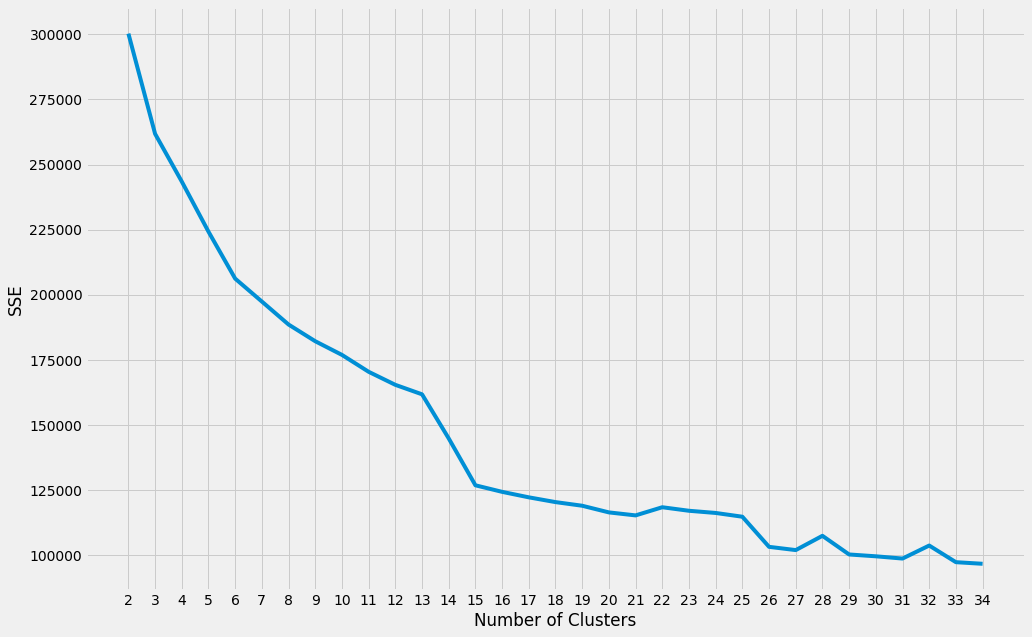

In [130]:
plt.style.use("fivethirtyeight")
plt.plot(range(MIN_RANGE, MAX_RANGE), sse_list)
plt.xticks(range(MIN_RANGE, MAX_RANGE))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### Silhouette Coefficents

The silhouette value is a measure of how similar an object is to its own cluster
        (cohesion) compared to other clusters (separation). Returns an array of silhouette_coefficients
        from each iteration of Kmeans so they can be plotted for best K clusters.  Looking for value closest to 1. Takes forever to run.

In [ ]:
#%%time
silhouettes = cluster_utils.ClusteringUtility.get_silhouette_for_plt_kmeans(df_merged_std, None, MIN_RANGE, MAX_RANGE, n_jobs=3)

In [ ]:
pd.Series(silhouettes).to_csv("silhouettes.csv")

In [ ]:
silhouettes = pd.read_csv("silhouettes.csv")
silhouettes =  silhouettes.iloc[:,1].to_list()
silhouettes

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(MIN_RANGE, MAX_RANGE), silhouettes)
plt.xticks(range(MIN_RANGE, MAX_RANGE))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Ceofficent")
plt.show()

In [ ]:
NumberOfClusters=range(MIN_RANGE, MAX_RANGE)
Optimal_NumberOf_Components=NumberOfClusters[silhouettes.index(max(silhouettes))]
print ("Optimal number of components is:")
print (Optimal_NumberOf_Components)

#### This looks off to me. Either that, a very low number of clusters is the best clustering for Kmeans. Ill continue to explore other options in a bit. I will go with 6 for now. 

#### Kmeans Clustering

In [7]:
#Actual Clustering
clusters = cluster_utils.ClusteringUtility.fit_kmeans(df_merged_std, n_clusters = 6) # Optimal_NumberOf_Components

In [8]:
df_merged['cluster'] = clusters

In [9]:
df_merged['cluster'].value_counts()

3    6472
5    5886
1    4041
0    2339
4    1187
2      75
Name: cluster, dtype: int64

### UMAP color coded by Kmeans

https://umap-learn.readthedocs.io/en/latest/

Lets color all our UMAP embeddng points with the output labels from Kmeans clustering to see visually if our clusters make sense.

Each point in the embedding is a unique userid and their behavior over 3 months. I want to make sure I don't get garbage from my clustering. An embedding is great at collapsing things down to the 
fundamental peices that make up that user! We can create a UMAP embedding, look at this in 2D, then run Kmeans on the data and assign each userid a cluster number. Then, based on the cluster number, we assign a color to the umap point! We can 
then visually see what was grouped together by Kmeans, vs the embedding!

For the UMAP we will want a larger n_neighbors value – small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters. In this case we’ll double it from the default 15 up to 30. https://umap-learn.readthedocs.io/en/latest/clustering.html

We can see there is good speration between these clusters. However, you can see that you might be able to seperate some of those clusters into two. With more time, I think it would be good to explore a lot more options than just 6 groups. However, for this time window, lets go simple. We can see a good drop in the SSE curve there. Lets just see if we are going in the right direction. 


In [10]:
def draw_umap(df, n_neighbors=30):
    df_standardized = StandardScaler().fit_transform(df)
    standard_embedding = umap.UMAP(random_state=42, n_neighbors=n_neighbors).fit_transform(df_standardized)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=df.cluster.astype(int), s=1.4, cmap='Spectral')
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

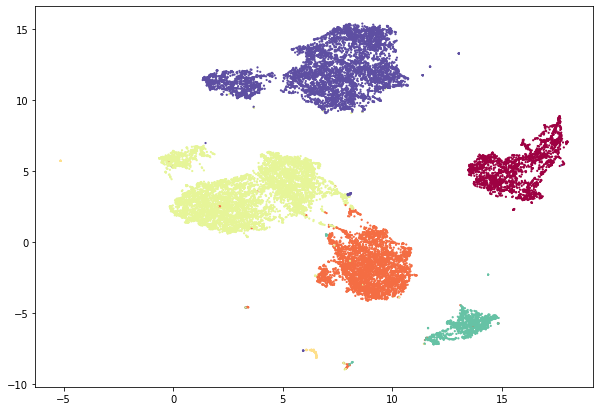

In [11]:
# Lets look at the KMeans color coded UMAP
for n in tqdm([4]):
     draw_umap(df_merged, n) 

In [12]:
#Not too bad

In [13]:
df_merged.drop(columns =['cluster'], inplace = True)
df_merged.head()

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')"
userid,,,,,,,,,,,,,,,,,,,,,
30077922,107,9,0,218,81,73,69,0,68,49,...,45,0,42,32,20,3,0,96,75,0
27079984,147,7,0,232,3,68,49,3,0,50,...,6,0,46,40,17,3,0,73,68,0
22243370,216,10,0,164,18,64,59,3,73,50,...,53,0,69,43,20,0,0,81,89,0
1983434,22,0,0,28,0,14,7,0,0,7,...,1,0,5,1,1,7,0,20,8,0
21862413,113,22,0,220,68,65,57,5,27,49,...,40,0,81,79,32,53,0,101,65,0


### HDBSCAN
https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html

I wanted to try some other kinds of clustering algorithms, after all, each has different benifits and draw backs.

HDBSCAN extends DBSCAN by converting it into a hierarchical clustering algorithm, and then doing this extract flat clustering technique. The link I posted above made this one look promising for uneven sized clusters. 


For HDBScan we can modify min_cluster_size and min_samples. For min_cluster_size, this is the smallest grouping you would be willing to consider a cluster.
Then there is min_samples, this is a measure of how conservative you want your clusters to be. The larger the min_samples, the more conservative you are and more points are declared as noise. Clusters will be more likely dense areas. I don't want to really put a lot into noise.


In [81]:
df_merged_std = StandardScaler().fit_transform(df_merged)

In [82]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples = 5)

clusters = clusterer.fit(df_merged_std)
df_merged['cluster'] = clusters.labels_
print("MAX : ", clusters.labels_.max())
df_merged.cluster.value_counts()

MAX :  2


 2    19723
-1      194
 1       43
 0       40
Name: cluster, dtype: int64

In [ ]:
# Lets look at the KMeans color coded UMAP - this one basically looks like it is all one color - So lets not use this one. I tried all sorts of cluster sizes and min_samples at this point. This is only one of them.
draw_umap(df_merged, n) 

#### Before we move one from HDBSCAN, like try UMAP Enhanced clustering:
https://umap-learn.readthedocs.io/en/latest/clustering.html

"UMAP enhanced clustering
Our goal is to make use of UMAP to perform non-linear manifold aware dimension reduction so we can get the dataset down to a number of dimensions small enough for a density based clustering algorithm to make progress. One advantage of UMAP for this is that it doesn’t require you to reduce to only two dimensions – you can reduce to 10 dimensions instead since the goal is to cluster, not visualize, and the performance cost with UMAP is minimal.The next thing to be aware of is that when using UMAP for dimension reduction you will want to select different parameters than if you were using it for visualization. First of all we will want a larger n_neighbors value – small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters. In this case we’ll double it from the default 15 up to 30. Second it is beneficial to set min_dist to a very low value. Since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters. In this case we will simply set min_dist to be 0."

In [74]:
df_merged.drop(columns =['cluster'], inplace = True)
df_merged.head()

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')"
userid,,,,,,,,,,,,,,,,,,,,,
25152222,164,64,0,234,33,65,57,2,0,54,...,26,0,137,165,44,52,0,116,64,0
26887856,226,114,0,318,136,77,75,9,162,81,...,72,0,221,268,178,83,0,158,161,0
5236413,222,62,0,337,70,87,86,11,85,83,...,76,0,142,152,51,40,0,167,122,0
25163455,156,13,0,309,164,69,67,11,66,54,...,53,0,108,108,34,32,0,119,102,0
21847904,137,20,1,213,25,67,63,14,50,49,...,45,0,64,93,28,31,0,103,84,0


In [84]:
clusterable_embedding = umap.UMAP(
    n_neighbors=300,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(df_merged_std)

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples = 1)

clusters = clusterer.fit(clusterable_embedding)
df_merged['cluster'] = clusters.labels_
print(clusters.labels_.max())
df_merged.cluster.value_counts()

# -1 means outlier... this doesn't look right to me!

599


-1      5258
 42      280
 456     257
 82      165
 382     136
        ... 
 594      10
 8        10
 412      10
 178      10
 330      10
Name: cluster, Length: 601, dtype: int64

In [85]:
def draw_umap(df, n_neighbors=3):
    df_standardized = StandardScaler().fit_transform(df)
    standard_embedding = umap.UMAP(random_state=42, n_neighbors=n_neighbors).fit_transform(df_standardized)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=df.cluster.astype(int), s=1.4, cmap='Spectral')
    plt.show()

Better than the first HDBScan from the looks of it, but not as good as Kmeans

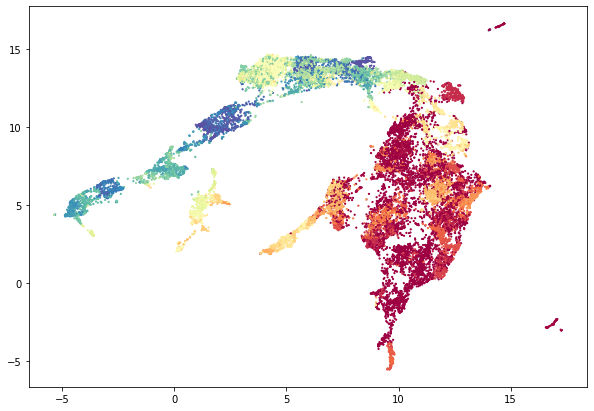

In [86]:
draw_umap(df_merged, 8)

### Agglomerative Clustering
https://www.statisticshowto.com/agglomerative-clustering/

"In agglomerative clustering, each document is treated as a single cluster at the beginning of the algorithm. After that, clusters can be combined through a variety of methods. They all involve calculating dissimilarities between objects; Exactly how that dissimilarity is calculated can vary. The most commonly used are:

* Single Linkage: similarity is calculated for the closest pair. One drawback is that groups with close pairs can merge sooner than is optimal, even if those groups have overall dissimilarity.

* Complete Linkage: calculates similarity of the farthest away pair. One disadvantage to this method is that outliers can cause less-than-optimal merging.

* Average Linkage, or group linkage: similarity is calculated between groups of objects, rather than individual objects.

* Centroid Method: each iteration merges the clusters with the most similar centroid. A centroid is the average of all points in the system."

I am going to try a few of these linkages and show the one that seems to be looking best.

In [33]:
df_merged.drop(columns =['cluster'], inplace = True)
df_merged_std = StandardScaler().fit_transform(df_merged)

In [ ]:
clustering = AgglomerativeClustering(n_clusters = 13).fit(df_merged_std)
clustering.labels_
df_merged['cluster'] = clustering.labels_

In [ ]:
draw_umap(df_merged, 4)

#### Further Exploration

There are tons of different clustering algorithms each with their own benefits and drawbacks. With more time, I would be worth reseraching these and trying some more out potentially.


### Moving forward:
For now I have to make a call for time sake... I am going to go with Kmeans after all.

From my notebook called Exploration, I created a table from all user traffic. This is what I learned below:

*  "General Browsing" accounts for about 50% of all traffic. It has the most uploads and downlods by a lot.
*  "P2P", "Image Host", and "Tunnel" are very rare events.
*  Most users is "General Browsing", "Enterprise", "WebSearch", "Webmail, "Business", "IT Services"....All about 95% of users. There are some close runner ups too. 

I expect that the big clusters will have that common 95% of user application use appclasses.  Those tiny clusters might have things like Tunneling or Image Host.
Lets take a gander at those clusters

In [8]:
def show_cluster(df, k):
    non_zeros = []
    df_k = df[df['cluster'] == k]
    for i in range(len(df_k.columns)):
        if df_k.iloc[:, i].any() != 0:
            non_zeros.append(i)
    print(non_zeros)
    print(len(non_zeros))
    display(df_k.iloc[:, non_zeros])
    print(df_k.iloc[:, non_zeros].columns)

In [9]:
# K means 
df_merged_std = StandardScaler().fit_transform(df_merged)
clusters = cluster_utils.ClusteringUtility.fit_kmeans(df_merged_std, n_clusters = 6)
df_merged['cluster'] = clusters
df_merged['cluster'].value_counts()

4    3284
2    2852
1    1957
0    1226
5     645
3      36
Name: cluster, dtype: int64

In [10]:
# Has Image host
show_cluster(df_merged, 1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21]
20


,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')","('days_accessed', 'Image host')","('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')",cluster
userid,,,,,,,,,,,,,,,,,,,,
5235966,193,43,0,300,189,85,75,19,72,74,0.0,45,0,111,110,23,42,131,90,1
24376840,308,59,0,432,126,87,102,15,83,84,0.0,77,0,170,199,61,120,195,103,1
21305983,229,120,1,315,118,75,77,15,90,82,0.0,63,0,206,187,77,58,185,82,1
21843258,158,16,0,322,33,79,72,2,109,63,0.0,56,0,49,92,82,13,104,132,1
24352591,218,110,0,264,113,63,66,1,46,51,0.0,54,0,172,205,37,16,190,69,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4719077,223,29,0,352,238,83,81,7,101,92,0.0,78,0,153,196,56,19,120,121,1
26548517,244,88,0,275,82,65,64,31,39,94,0.0,11,0,220,213,45,97,165,67,1
25150462,220,43,0,291,147,81,79,12,68,62,0.0,72,0,179,118,54,44,155,127,1


Index(['('days_accessed', 'Business')', '('days_accessed', 'Consumer Apps')',
       '('days_accessed', 'DNS Over HTTPS Services')',
       '('days_accessed', 'Enterprise')', '('days_accessed', 'File Share')',
       '('days_accessed', 'General Browsing')',
       '('days_accessed', 'Hosting Providers')',
       '('days_accessed', 'Human Resources')', '('days_accessed', 'IM')',
       '('days_accessed', 'IT Services')', '('days_accessed', 'Image host')',
       '('days_accessed', 'Mobile App Download')', '('days_accessed', 'P2P')',
       '('days_accessed', 'Sales and Marketing')',
       '('days_accessed', 'Social Networking')',
       '('days_accessed', 'Streaming Media')',
       '('days_accessed', 'System and Development')',
       '('days_accessed', 'WebSearch')', '('days_accessed', 'Webmail')',
       'cluster'],
      dtype='object')


In [11]:
# not image host or tunnel

''' in here tunneling is not always 0, but it is usually 0. This might be evidence to have more classes / more rules.'''
show_cluster(df_merged, 2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21]
21


,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",cluster
userid,,,,,,,,,,,,,,,,,,,,,
26958773,117,1,0,170,98,74,50,2,0,53,...,0,0,12,22,0,2,104,59,0,2
27044164,111,7,0,165,68,43,42,25,1,31,...,7,0,55,29,9,17,59,44,0,2
5172166,129,9,0,133,61,54,51,0,53,40,...,36,0,34,38,14,7,79,54,0,2
10489166,98,4,0,191,7,62,56,8,53,44,...,9,0,19,14,2,1,66,62,0,2
21846806,123,9,0,191,93,64,62,0,30,54,...,26,0,42,55,46,10,77,64,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27118879,125,2,0,227,9,67,62,4,0,47,...,1,0,20,16,6,34,64,67,0,2
16830711,115,21,0,195,1,53,49,1,30,43,...,0,0,55,27,18,31,73,59,0,2
3077305,130,8,0,230,103,70,30,6,0,51,...,11,0,70,69,79,44,101,69,0,2


Index(['('days_accessed', 'Business')', '('days_accessed', 'Consumer Apps')',
       '('days_accessed', 'DNS Over HTTPS Services')',
       '('days_accessed', 'Enterprise')', '('days_accessed', 'File Share')',
       '('days_accessed', 'General Browsing')',
       '('days_accessed', 'Hosting Providers')',
       '('days_accessed', 'Human Resources')', '('days_accessed', 'IM')',
       '('days_accessed', 'IT Services')', '('days_accessed', 'Image host')',
       '('days_accessed', 'Mobile App Download')', '('days_accessed', 'P2P')',
       '('days_accessed', 'Sales and Marketing')',
       '('days_accessed', 'Social Networking')',
       '('days_accessed', 'Streaming Media')',
       '('days_accessed', 'System and Development')',
       '('days_accessed', 'WebSearch')', '('days_accessed', 'Webmail')',
       '('days_accessed', 'miscellaneous module')', 'cluster'],
      dtype='object')


In [12]:
# not have tunneling or image host
show_cluster(df_merged, 0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20]
19


,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')","('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')"
userid,,,,,,,,,,,,,,,,,,,
26759497,70,4,0,121,43,36,29,5,0,28,3,0,23,19,5,9,34,36,0
5182470,67,3,0,116,1,48,36,1,0,31,1,0,10,9,2,4,26,45,0
5230369,58,31,0,91,5,30,27,0,40,22,19,0,40,54,25,14,52,29,0
5226199,28,10,0,37,0,10,10,0,0,9,7,0,33,17,5,9,24,10,0
54379286,85,19,0,83,0,35,26,2,0,28,17,0,40,48,17,21,59,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815953,71,0,0,104,0,73,0,0,0,10,0,0,0,0,0,0,44,0,0
27057333,86,3,0,125,54,44,25,1,21,27,18,0,19,18,5,4,41,43,0
4725394,60,0,0,50,21,21,19,3,20,13,5,0,8,4,0,0,29,23,0


Index(['('days_accessed', 'Business')', '('days_accessed', 'Consumer Apps')',
       '('days_accessed', 'DNS Over HTTPS Services')',
       '('days_accessed', 'Enterprise')', '('days_accessed', 'File Share')',
       '('days_accessed', 'General Browsing')',
       '('days_accessed', 'Hosting Providers')',
       '('days_accessed', 'Human Resources')', '('days_accessed', 'IM')',
       '('days_accessed', 'IT Services')',
       '('days_accessed', 'Mobile App Download')', '('days_accessed', 'P2P')',
       '('days_accessed', 'Sales and Marketing')',
       '('days_accessed', 'Social Networking')',
       '('days_accessed', 'Streaming Media')',
       '('days_accessed', 'System and Development')',
       '('days_accessed', 'WebSearch')', '('days_accessed', 'Webmail')',
       '('days_accessed', 'miscellaneous module')'],
      dtype='object')


#### All Variations:

The main variatons I see are some clusters either have or don't have the following appclasses: 
* Tunnel
* Image Host
* Miscellaneous Module.

So, it can be one of these, two of these, or all three of these, or none. I only have 6 clusters so I might be missing one of the variations, but for quick and dirty this is going to have to be for now. 

### Assumptions and questions to ask....

 
* We are wanting to make user groups that allow or restrict access. Some of these clusters have very for observations. This brings me to an important point about clustering. Clustering is great at showing groups of behavior, but it is also good at outlier detection. Tread carefully! :)
A user that falls in a low population cluster might have really anomalous application access history. We might actually want to block this user from accessing these applications! This might be something we want to limit with a user group. I have a proposal on how to deal with this in Task 2. In task 2, we add a new feature, department Id for each user ID. IF we have users in their own tiny cluster, we might want to look up their department. Then, once we have the department ID, take the mode cluster assignment for that department. Take that user in that low population cluster and assign them the group cluster that is the mode cluster number of the department they work in. This is a naive approach, making the assumption that the user is most likely to need the access of what is most common in the department they work in. I think we could get a little better if we had their job title too.

* It might be worth finding anomolous users and leaving these particular observations our of your cluster/groupid assignment. We wouldn't want to give these anomolous users (who could be missbehaving...) special access! (that essentially will be your low population ones I just discussed) 

* It might be intersting to explore how these clusters change over time. A user might not use an application, and then one day, BAM it happens.

* Also might be cool if there was location of userid access. Like lat/lon.

* If we could identify each anomolous inidividual access and remove those before aggregating could be helpful. I would think we would want to model user behavior that is in line with what an individual should be doing. 

#### For now, I am writing out all clusters, including low population ones out for Task 1. Lets move on to task 2.

### Writing out Task 1 userid,groupid

In [26]:
write_df = df_merged.rename(columns ={'cluster':'groupid'}).reset_index()
write_df.head()

,userid,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')",...,"('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",groupid
0,30077922,107,9,0,218,81,73,69,0,68,...,0,42,32,20,3,0,96,75,0,3
1,27079984,147,7,0,232,3,68,49,3,0,...,0,46,40,17,3,0,73,68,0,5
2,22243370,216,10,0,164,18,64,59,3,73,...,0,69,43,20,0,0,81,89,0,3
3,1983434,22,0,0,28,0,14,7,0,0,...,0,5,1,1,7,0,20,8,0,0
4,21862413,113,22,0,220,68,65,57,5,27,...,0,81,79,32,53,0,101,65,0,3


In [27]:
write_df.to_csv("task_1_output.csv", mode='w', columns=['userid','groupid'], index=False)

## Task 2

Lets add Departments as a new features! I already added in a few features of my own - how many unique applications were accessed per class and for how many days.

Now we are adding in one more. The department for each userid. Lets just append it on and see if we get more clean clusters!

In [16]:
# lets drop clusters...
df_merged = df_merged.drop(columns=['cluster']).reset_index()
df_merged.head()

,userid,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')",...,"('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')"
0,5221500,173,89,0,182,138,48,50,31,49,...,45,0,139,147,89,51,0,100,90,0
1,26958773,117,1,0,170,98,74,50,2,0,...,0,0,12,22,0,2,0,104,59,0
2,5235966,193,43,0,300,189,85,75,19,72,...,45,0,111,110,23,42,0,131,90,0
3,51178272,153,44,0,250,72,76,53,2,56,...,40,0,137,129,33,55,0,120,80,0
4,28399870,145,69,0,290,31,73,53,12,12,...,27,0,129,83,26,35,0,141,78,0


In [17]:
gdd.download_file_from_google_drive(file_id='18xods8LNcS5zUmwWKCJoK1_hnjkZQuWh',
                                    dest_path='./userid2departmentid.csv',
                                    unzip=True)

In [18]:
userid2departmentid = pd.read_csv('userid2departmentid.csv')
userid2departmentid_dict = userid2departmentid.set_index('userid')['departmentid'].to_dict()

In [19]:
userid2departmentid

,userid,departmentid
0,28463183,23838811
1,32550509,28014937
2,26873555,17192789
3,27068215,24148455
4,32552297,27157825
...,...,...
86840,65124421,4274786484
86841,5168607,4274786484
86842,28389009,4274786484
86843,25344248,4274786484


In [20]:
# Map userid names to department id's
df_merged['departmentid'] = df_merged['userid'].map(userid2departmentid_dict)

In [21]:
df_merged = df_merged.set_index(['userid'])

In [22]:
df_merged.head()

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",departmentid
userid,,,,,,,,,,,,,,,,,,,,,
5221500,173,89,0,182,138,48,50,31,49,44,...,0,139,147,89,51,0,100,90,0,5239947.0
26958773,117,1,0,170,98,74,50,2,0,53,...,0,12,22,0,2,0,104,59,0,21573472.0
5235966,193,43,0,300,189,85,75,19,72,74,...,0,111,110,23,42,0,131,90,0,14763293.0
51178272,153,44,0,250,72,76,53,2,56,57,...,0,137,129,33,55,0,120,80,0,14099564.0
28399870,145,69,0,290,31,73,53,12,12,55,...,0,129,83,26,35,0,141,78,0,17596188.0


In [23]:
# Departments are categories
df_merged['departmentid'] = df_merged['departmentid'].astype('category')

In [24]:
df_merged.isna().sum()

('days_accessed', 'Business')                   0
('days_accessed', 'Consumer Apps')              0
('days_accessed', 'DNS Over HTTPS Services')    0
('days_accessed', 'Enterprise')                 0
('days_accessed', 'File Share')                 0
('days_accessed', 'General Browsing')           0
('days_accessed', 'Hosting Providers')          0
('days_accessed', 'Human Resources')            0
('days_accessed', 'IM')                         0
('days_accessed', 'IT Services')                0
('days_accessed', 'Image host')                 0
('days_accessed', 'Mobile App Download')        0
('days_accessed', 'P2P')                        0
('days_accessed', 'Sales and Marketing')        0
('days_accessed', 'Social Networking')          0
('days_accessed', 'Streaming Media')            0
('days_accessed', 'System and Development')     0
('days_accessed', 'Tunnel')                     0
('days_accessed', 'WebSearch')                  0
('days_accessed', 'Webmail')                    0


In [25]:
# dropping one user without department id
df_merged.dropna(inplace = True)

In [26]:
df_merged.isna().sum()

('days_accessed', 'Business')                   0
('days_accessed', 'Consumer Apps')              0
('days_accessed', 'DNS Over HTTPS Services')    0
('days_accessed', 'Enterprise')                 0
('days_accessed', 'File Share')                 0
('days_accessed', 'General Browsing')           0
('days_accessed', 'Hosting Providers')          0
('days_accessed', 'Human Resources')            0
('days_accessed', 'IM')                         0
('days_accessed', 'IT Services')                0
('days_accessed', 'Image host')                 0
('days_accessed', 'Mobile App Download')        0
('days_accessed', 'P2P')                        0
('days_accessed', 'Sales and Marketing')        0
('days_accessed', 'Social Networking')          0
('days_accessed', 'Streaming Media')            0
('days_accessed', 'System and Development')     0
('days_accessed', 'Tunnel')                     0
('days_accessed', 'WebSearch')                  0
('days_accessed', 'Webmail')                    0


In [27]:
kprot_data = df_merged.copy()

#Pre-processing numericals - does a power transformation on the nums
for c in df_merged.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = [21] #make sure to specify correct indices

In [28]:
#OPTIONAL: Elbow plot with cost (will take a LONG time)
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(5, 18)): # with more time I would make this a larger range
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=[21])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show() # best was 7

  0%|          | 0/13 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3816, ncost: 117830.43287454676
Run: 1, iteration: 2/100, moves: 1185, ncost: 116640.88735178155
Run: 1, iteration: 3/100, moves: 855, ncost: 115843.2449949208
Run: 1, iteration: 4/100, moves: 578, ncost: 115509.93124162391
Run: 1, iteration: 5/100, moves: 299, ncost: 115419.38184553733
Run: 1, iteration: 6/100, moves: 131, ncost: 115396.96876251869
Run: 1, iteration: 7/100, moves: 87, ncost: 115385.73319003846
Run: 1, iteration: 8/100, moves: 69, ncost: 115378.32860334349
Run: 1, iteration: 9/100, moves: 64, ncost: 115372.6044654645
Run: 1, iteration: 10/100, moves: 82, ncost: 115363.70607748374
Run: 1, iteration: 11/100, moves: 89, ncost: 115354.52852653495
Run: 1, iteration: 12/100, moves: 49, ncost: 115351.38379340917
Run: 1, iteration: 13/100, moves: 25, ncost: 115350.60663400739
Run: 1, iteration: 14/100, moves: 18, ncost: 115349.84045694253
Run: 1, iteration: 15/100, 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_44191/2231936114.py", line 17, in <module>
    fig.show() # best was 7
  File "/opt/conda/lib/python3.7/site-packages/plotly/basedatatypes.py", line 3398, in show
    return pio.show(self, *args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/_plotly_utils/importers.py", line 36, in __getattr__
    class_module = importlib.import_module(rel_module, parent_name)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, 

TypeError: object of type 'NoneType' has no len()

### KPrototypes

We got mixed data types this time. Departments make more sense as a catagorical value than a numerical value. We have numerical and catagorical data. We cannot just simply use Euclidean distance on a catagorical.

Kprototypes measures distance between numerical features using Euclidean distance (like K-means) but also measure the distance between categorical features using the number of matching categories.

In [29]:
#Actual clustering
kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Prints the count of each cluster group
pd.Series(clusters).value_counts()

13    1597
1     1291
6     1125
2     1100
12    1002
0      945
3      869
4      765
9      653
11     281
5      238
10      68
14      57
8        7
7        1
dtype: int64

In [30]:
#Add clusters to data
df_merged['cluster'] = clusters
df_merged

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",departmentid,cluster
userid,,,,,,,,,,,,,,,,,,,,,
5221500,173,89,0,182,138,48,50,31,49,44,...,139,147,89,51,0,100,90,0,5239947.0,2
26958773,117,1,0,170,98,74,50,2,0,53,...,12,22,0,2,0,104,59,0,21573472.0,0
5235966,193,43,0,300,189,85,75,19,72,74,...,111,110,23,42,0,131,90,0,14763293.0,13
51178272,153,44,0,250,72,76,53,2,56,57,...,137,129,33,55,0,120,80,0,14099564.0,13
28399870,145,69,0,290,31,73,53,12,12,55,...,129,83,26,35,0,141,78,0,17596188.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26496285,147,62,0,239,25,81,58,18,24,66,...,219,97,25,13,0,96,86,0,28486116.0,3
418794,177,53,0,239,141,66,65,5,83,69,...,133,207,77,27,0,113,126,0,33410940.0,13
5787256,97,19,0,187,69,71,63,0,0,48,...,43,14,8,10,0,80,69,0,27151241.0,6


In [31]:
def draw_umap(df, n_neighbors=3):
    df_standardized = StandardScaler().fit_transform(df)
    standard_embedding = umap.UMAP(random_state=42, n_neighbors=n_neighbors).fit_transform(df_standardized)
    plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=df.cluster.astype(int), s=1.4, cmap='Spectral')
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

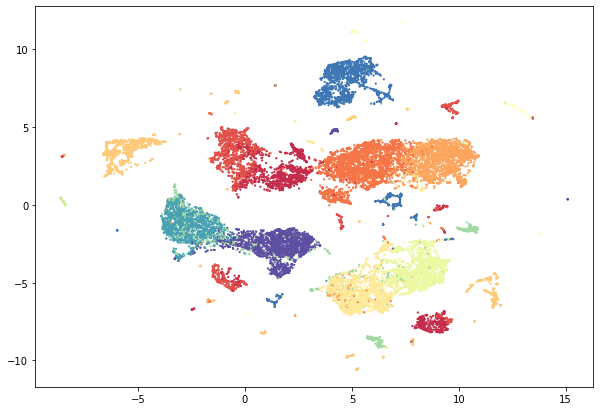

In [152]:
# Lets look at the KMeans color coded UMAP
for n in tqdm([4]):
     draw_umap(df_merged, n) 

In [32]:
df_merged['cluster'].value_counts()

13    1597
1     1291
6     1125
2     1100
12    1002
0      945
3      869
4      765
9      653
11     281
5      238
10      68
14      57
8        7
7        1
Name: cluster, dtype: int64

In [33]:
df_merged[ df_merged['cluster'] == 6]

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",departmentid,cluster
userid,,,,,,,,,,,,,,,,,,,,,
13771626,125,3,0,188,62,62,62,5,0,44,...,26,25,10,1,0,79,75,0,24870661.0,6
25209302,138,5,0,257,4,71,43,9,0,65,...,9,3,12,62,0,65,71,0,21605541.0,6
5147612,152,43,0,277,92,88,85,1,0,63,...,70,28,8,19,0,101,87,0,58290434.0,6
27194132,137,2,0,215,16,56,42,28,0,47,...,53,38,33,33,0,86,56,0,21842092.0,6
25208237,112,33,0,173,62,62,54,1,0,45,...,73,48,4,4,0,103,56,0,4756587.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24374495,117,3,0,242,12,71,57,0,0,51,...,58,53,25,43,0,93,72,0,17658595.0,6
7921380,118,8,0,226,62,65,50,1,1,46,...,63,40,1,23,0,68,65,0,66371431.0,6
27118879,125,2,0,227,9,67,62,4,0,47,...,20,16,6,34,0,64,67,0,26637628.0,6


In [34]:
df_merged[ df_merged['cluster'] == 6]['departmentid'].value_counts()

25151944.0    9
26642958.0    6
21367457.0    6
21627411.0    6
25160065.0    6
             ..
21720278.0    0
21720398.0    0
21720430.0    0
21720542.0    0
23721823.0    0
Name: departmentid, Length: 4702, dtype: int64

In [35]:
# Has Image host
df_merged[ df_merged['cluster'] == 1]

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",departmentid,cluster
userid,,,,,,,,,,,,,,,,,,,,,
769913,109,10,0,205,74,65,61,1,0,47,...,99,104,33,17,0,159,106,0,25160219.0,1
17156300,159,17,0,72,3,74,69,2,51,38,...,52,42,76,6,0,137,120,0,17156734.0,1
21843258,158,16,0,322,33,79,72,2,109,63,...,49,92,82,13,0,104,132,0,21843478.0,1
24146452,194,14,0,253,165,76,64,2,50,62,...,66,46,18,44,0,91,78,0,14819177.0,1
21846806,123,9,0,191,93,64,62,0,30,54,...,42,55,46,10,0,77,64,0,21852881.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25162130,146,13,0,314,34,81,67,5,62,57,...,41,40,30,30,0,150,85,0,25162131.0,1
22958392,171,29,0,242,115,71,68,1,70,51,...,78,83,44,3,0,114,84,0,23353913.0,1
23210269,164,25,0,212,75,59,59,3,59,49,...,97,86,26,34,0,103,86,0,54862140.0,1


In [36]:
df_merged[ df_merged['cluster'] == 1]['departmentid'].value_counts()

17658595.0    8
21847878.0    7
17002381.0    7
28412737.0    6
24262633.0    5
             ..
21622007.0    0
21622714.0    0
21628615.0    0
21632132.0    0
23721823.0    0
Name: departmentid, Length: 4702, dtype: int64

### Write task 2 to disk

In [163]:
write_df = df_merged.rename(columns ={'cluster':'groupid'}).reset_index()
write_df.head()

,userid,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')",...,"('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",departmentid,groupid
0,27991944,170,43,0,283,174,73,27,0,80,...,168,155,55,18,0,119,74,0,27991945,4
1,5240874,169,14,0,289,11,80,77,1,0,...,80,66,16,42,0,110,79,0,55204105,6
2,32860218,279,48,0,373,228,85,87,2,87,...,155,155,88,34,0,164,151,0,12578274,12
3,21588842,233,40,0,295,43,78,76,1,78,...,200,180,29,40,0,159,105,0,21720036,4
4,13671820,174,24,1,312,114,84,78,9,74,...,95,93,35,47,0,122,124,0,14763290,10


In [164]:
write_df.to_csv("task_2_output.csv", mode='w', columns=['userid','groupid'], index=False)

### Task 3

First - Create a dictionary of userid to a list of all appclasses they have in their cluster (groupid)

Take the application and look up appclass from dicionary we already have. 

For each application and for each user, check the list of all applcasses in the users groupid, if the application's appclass is in that list, put a 1, else put a 0


I am using clusters from task 2

In [156]:
# Create dictionary look up of all userid as keys and all values is the appclasses that are not 0. I am using Task 1's output here.

In [41]:
df_merged

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",departmentid,cluster
userid,,,,,,,,,,,,,,,,,,,,,
5221500,173,89,0,182,138,48,50,31,49,44,...,139,147,89,51,0,100,90,0,5239947.0,2
26958773,117,1,0,170,98,74,50,2,0,53,...,12,22,0,2,0,104,59,0,21573472.0,0
5235966,193,43,0,300,189,85,75,19,72,74,...,111,110,23,42,0,131,90,0,14763293.0,13
51178272,153,44,0,250,72,76,53,2,56,57,...,137,129,33,55,0,120,80,0,14099564.0,13
28399870,145,69,0,290,31,73,53,12,12,55,...,129,83,26,35,0,141,78,0,17596188.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26496285,147,62,0,239,25,81,58,18,24,66,...,219,97,25,13,0,96,86,0,28486116.0,3
418794,177,53,0,239,141,66,65,5,83,69,...,133,207,77,27,0,113,126,0,33410940.0,13
5787256,97,19,0,187,69,71,63,0,0,48,...,43,14,8,10,0,80,69,0,27151241.0,6


In [42]:
df = df_merged.loc[:, df_merged.columns != 'departmentid']

In [43]:
df.head()

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",cluster
userid,,,,,,,,,,,,,,,,,,,,,
5221500,173,89,0,182,138,48,50,31,49,44,...,0,139,147,89,51,0,100,90,0,2
26958773,117,1,0,170,98,74,50,2,0,53,...,0,12,22,0,2,0,104,59,0,0
5235966,193,43,0,300,189,85,75,19,72,74,...,0,111,110,23,42,0,131,90,0,13
51178272,153,44,0,250,72,76,53,2,56,57,...,0,137,129,33,55,0,120,80,0,13
28399870,145,69,0,290,31,73,53,12,12,55,...,0,129,83,26,35,0,141,78,0,3


In [117]:
# group by cluster - get all columns that are not 0
grouped_df = df.groupby(['cluster']).sum()
grouped_df

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'Mobile App Download')","('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')"
cluster,,,,,,,,,,,,,,,,,,,,,
0,91434,3468,4,156453,23954,54314,33710,2125,2082,39507,...,3624,0,21249,15625,4203,20684,0,54808,52520,0
1,196428,23345,0,300737,102348,90220,75230,3607,74261,70889,...,53191,0,93958,87288,38726,25088,0,136216,109095,0
2,163523,54803,0,216058,53565,64370,51268,8232,39594,54541,...,34315,0,132974,121858,45491,37216,0,128245,76421,0
3,165443,35115,0,249387,66325,66348,57476,9550,9577,56704,...,17077,0,106313,87683,29790,42225,0,115274,70443,0
4,201758,86353,0,251497,104666,62817,60678,12299,69585,63143,...,52386,0,184967,182887,67287,44979,0,141784,104255,0
5,41241,17381,880,54348,15387,15557,13183,2441,9642,14016,...,7928,0,38414,35106,16316,8934,0,34417,20805,0
6,157904,13484,0,265644,56557,76806,60523,5009,5660,59184,...,10366,0,61594,48051,16346,39849,0,96382,77607,0
7,163,73,0,255,164,69,64,5,1,70,...,11,0,160,134,40,30,1,128,66,0
8,1608,668,13,1710,672,501,436,64,527,485,...,365,0,1499,1464,487,438,0,1167,704,1


In [118]:
cols = grouped_df.columns
bt = grouped_df.apply(lambda x: x > 0)
bt
grouped_df['appclass_list'] = bt.apply(lambda x: list(cols[x.values]), axis=1)
import re
def clean_app(cell):
    return [re.sub(r"[()]","", x.replace("days_accessed", "")).replace("'", '').replace(',', '').lstrip() for x in cell]

grouped_df['appclass_list'] = grouped_df.appclass_list.map(clean_app)

In [121]:
grouped_df

,"('days_accessed', 'Business')","('days_accessed', 'Consumer Apps')","('days_accessed', 'DNS Over HTTPS Services')","('days_accessed', 'Enterprise')","('days_accessed', 'File Share')","('days_accessed', 'General Browsing')","('days_accessed', 'Hosting Providers')","('days_accessed', 'Human Resources')","('days_accessed', 'IM')","('days_accessed', 'IT Services')",...,"('days_accessed', 'P2P')","('days_accessed', 'Sales and Marketing')","('days_accessed', 'Social Networking')","('days_accessed', 'Streaming Media')","('days_accessed', 'System and Development')","('days_accessed', 'Tunnel')","('days_accessed', 'WebSearch')","('days_accessed', 'Webmail')","('days_accessed', 'miscellaneous module')",appclass_list
cluster,,,,,,,,,,,,,,,,,,,,,
0,91434,3468,4,156453,23954,54314,33710,2125,2082,39507,...,0,21249,15625,4203,20684,0,54808,52520,0,"[Business, Consumer Apps, DNS Over HTTPS Servi..."
1,196428,23345,0,300737,102348,90220,75230,3607,74261,70889,...,0,93958,87288,38726,25088,0,136216,109095,0,"[Business, Consumer Apps, Enterprise, File Sha..."
2,163523,54803,0,216058,53565,64370,51268,8232,39594,54541,...,0,132974,121858,45491,37216,0,128245,76421,0,"[Business, Consumer Apps, Enterprise, File Sha..."
3,165443,35115,0,249387,66325,66348,57476,9550,9577,56704,...,0,106313,87683,29790,42225,0,115274,70443,0,"[Business, Consumer Apps, Enterprise, File Sha..."
4,201758,86353,0,251497,104666,62817,60678,12299,69585,63143,...,0,184967,182887,67287,44979,0,141784,104255,0,"[Business, Consumer Apps, Enterprise, File Sha..."
5,41241,17381,880,54348,15387,15557,13183,2441,9642,14016,...,0,38414,35106,16316,8934,0,34417,20805,0,"[Business, Consumer Apps, DNS Over HTTPS Servi..."
6,157904,13484,0,265644,56557,76806,60523,5009,5660,59184,...,0,61594,48051,16346,39849,0,96382,77607,0,"[Business, Consumer Apps, Enterprise, File Sha..."
7,163,73,0,255,164,69,64,5,1,70,...,0,160,134,40,30,1,128,66,0,"[Business, Consumer Apps, Enterprise, File Sha..."
8,1608,668,13,1710,672,501,436,64,527,485,...,0,1499,1464,487,438,0,1167,704,1,"[Business, Consumer Apps, DNS Over HTTPS Servi..."


In [122]:
grouped_df['appclass_list'][0]

['Business',
 'Consumer Apps',
 'DNS Over HTTPS Services',
 'Enterprise',
 'File Share',
 'General Browsing',
 'Hosting Providers',
 'Human Resources',
 'IM',
 'IT Services',
 'Mobile App Download',
 'Sales and Marketing',
 'Social Networking',
 'Streaming Media',
 'System and Development',
 'WebSearch',
 'Webmail']

In [123]:
grouped_df['appclass_list'][10]

['Business',
 'Consumer Apps',
 'Enterprise',
 'File Share',
 'General Browsing',
 'Hosting Providers',
 'Human Resources',
 'IM',
 'IT Services',
 'Mobile App Download',
 'P2P',
 'Sales and Marketing',
 'Social Networking',
 'Streaming Media',
 'System and Development',
 'WebSearch',
 'Webmail']

In [124]:
cluster_to_appclass_dict = dict(zip(grouped_df.index, grouped_df.appclass_list))

In [125]:
userid_to_cluster = dict(zip(df.index, df.cluster))

In [139]:
#application to appclass 
import OrderedDict
app_2_class = pd.read_csv('app2appclass.csv')
app_2_class_dict = app_2_class.set_index('application')['appclass'].to_dict()
class_2_app_dict = app_2_class.groupby('appclass')['application'].apply(list).to_dict()

In [135]:
app_2_class

,appclass,application
0,IM,bYgZ7fdgKfHan/cMGw53vG38/Bs=
1,IM,vFJcnlW+X3FvJne9ZM2Zhxh7bAA=
2,IM,ZCC/v0R0aFYPf/W4FmwFK+0IE8w=
3,IM,f25DC11VpTinPRsg96CWjiR6NiQ=
4,IM,TtCsq/coR0EJMmlZG+4B/Bh93tQ=
...,...,...
448,DNS Over HTTPS Services,wtnHeuXxJYIhU+ASB9Yk3vUCjqM=
449,DNS Over HTTPS Services,WbH97n7GLdgR7i/SzrRHc9tmmZ8=
450,DNS Over HTTPS Services,pCXFccawN5aifuSW2ksmx2Ray38=
451,DNS Over HTTPS Services,VrldYReC90/WJcnRuiSefo6mt8I=


In [127]:
app_2_class.appclass.unique()

array(['IM', 'P2P', 'Tunnel', 'Webmail', 'Business', 'WebSearch',
       'Enterprise', 'File Share', 'Image host', 'IT Services',
       'Consumer Apps', 'Human Resources', 'Streaming Media',
       'General Browsing', 'Hosting Providers', 'Social Networking',
       'Mobile App Download', 'Sales and Marketing',
       'miscellaneous module', 'System and Development',
       'DNS Over HTTPS Services'], dtype=object)

In [128]:
app_2_class_dict

{'bYgZ7fdgKfHan/cMGw53vG38/Bs=': 'IM',
 'vFJcnlW+X3FvJne9ZM2Zhxh7bAA=': 'IM',
 'ZCC/v0R0aFYPf/W4FmwFK+0IE8w=': 'IM',
 'f25DC11VpTinPRsg96CWjiR6NiQ=': 'IM',
 'TtCsq/coR0EJMmlZG+4B/Bh93tQ=': 'IM',
 'OLo8LKoEzB2V/pAA38S4Y4afWto=': 'IM',
 '6qviJiawqIjQDpD+leDqB68+REc=': 'IM',
 'xNgngTOR1SBMM0exnt+WSdQFllE=': 'IM',
 'RSo7T9IEItOjSOK+78tMaotoqZE=': 'IM',
 '+M8BRZv1FcCOFE5afcUf7X5tMFA=': 'P2P',
 'YAIvVQ9lKeeGCktPmGZPmd6iMjU=': 'P2P',
 'vd8j+OAERd2I7mtgEVr2ONbaDkQ=': 'P2P',
 '4jjxwqbdop4mKJE7uaPwU4Wp5mU=': 'Tunnel',
 '6r35ThOZb1ehJNIvjVsf2lAVYwc=': 'Webmail',
 'Myxqrf3ynVO78bNd5Q6e5iLrI5E=': 'Webmail',
 'Mz0S21dlFSdtr1NZ/efNfB3E/U4=': 'Webmail',
 'MEY8dk6CkbyNY3sb4qAtQCrfP9o=': 'Webmail',
 'URgbZpieH1CvcYQRMfMilVabBug=': 'Webmail',
 'Cq6gSv9RRSKCU2+Qiy6fiDv5gqU=': 'Webmail',
 'dvRyz4ScBww8N9HGTTlPhOjLL4U=': 'Webmail',
 'ZDaSY0++7WLAHUgSVK6/0jr8/9U=': 'Webmail',
 'nhSh2NnBSBmpL42r+3+70/iz5aM=': 'Webmail',
 'bPQmJoS4eSXLtef2R62MDU3uHkU=': 'Webmail',
 '3waHkm7fxo3FwqTD5No3DdbCoZw=': 'Webmail',
 '

In [129]:
len(userid_to_cluster)

9999

In [132]:
app_2_class_dict

{'bYgZ7fdgKfHan/cMGw53vG38/Bs=': 'IM',
 'vFJcnlW+X3FvJne9ZM2Zhxh7bAA=': 'IM',
 'ZCC/v0R0aFYPf/W4FmwFK+0IE8w=': 'IM',
 'f25DC11VpTinPRsg96CWjiR6NiQ=': 'IM',
 'TtCsq/coR0EJMmlZG+4B/Bh93tQ=': 'IM',
 'OLo8LKoEzB2V/pAA38S4Y4afWto=': 'IM',
 '6qviJiawqIjQDpD+leDqB68+REc=': 'IM',
 'xNgngTOR1SBMM0exnt+WSdQFllE=': 'IM',
 'RSo7T9IEItOjSOK+78tMaotoqZE=': 'IM',
 '+M8BRZv1FcCOFE5afcUf7X5tMFA=': 'P2P',
 'YAIvVQ9lKeeGCktPmGZPmd6iMjU=': 'P2P',
 'vd8j+OAERd2I7mtgEVr2ONbaDkQ=': 'P2P',
 '4jjxwqbdop4mKJE7uaPwU4Wp5mU=': 'Tunnel',
 '6r35ThOZb1ehJNIvjVsf2lAVYwc=': 'Webmail',
 'Myxqrf3ynVO78bNd5Q6e5iLrI5E=': 'Webmail',
 'Mz0S21dlFSdtr1NZ/efNfB3E/U4=': 'Webmail',
 'MEY8dk6CkbyNY3sb4qAtQCrfP9o=': 'Webmail',
 'URgbZpieH1CvcYQRMfMilVabBug=': 'Webmail',
 'Cq6gSv9RRSKCU2+Qiy6fiDv5gqU=': 'Webmail',
 'dvRyz4ScBww8N9HGTTlPhOjLL4U=': 'Webmail',
 'ZDaSY0++7WLAHUgSVK6/0jr8/9U=': 'Webmail',
 'nhSh2NnBSBmpL42r+3+70/iz5aM=': 'Webmail',
 'bPQmJoS4eSXLtef2R62MDU3uHkU=': 'Webmail',
 '3waHkm7fxo3FwqTD5No3DdbCoZw=': 'Webmail',
 '

In [147]:
class_2_app_dict

{'Business': ['5cF/ckDTnsGipdR1R0RnZzJtCXE=',
  'gMlHUoVLuTH5rKqC+K6vt1ubt4s=',
  'C++ECsIKhMVFXHHYW2m9JgTZMGI=',
  'u/p3PlpjpepYybYgfmCMoBIOWSo=',
  'HG99oSpl6uGomXW4UUBppi3ZH/c=',
  'HQLkiSBhYaQ3nNlsPRPfu6yK5D0=',
  '9Osv32jxcf+rDvM/Cucz9pQTrkE=',
  'rSAqb40B6sXNA+aEf47LfqQ5zPo=',
  'ePDedgiNH13osO1yO7102N0nzQs=',
  'zH1sgRXr32cfWBmgLYqVTKQin0A=',
  'F/Iovn+u94FfVHVzflX4/73StLY=',
  'rog8/tbFG+JFGrRHCoAJATp6eXM=',
  'Jtuwg62qfC34VNCS9TA5IbOuM+k=',
  'BxMutJ0UNnRnZkDj2pv2Gwp+jR4=',
  'tL3hbJ6mxFtm1WpaZsoUPL+5m+A=',
  'SzjBp1WK8vcO6QDzZ9En9ynBn+M=',
  'xI5tjcl837aaKDCkLPQlCfa98DI=',
  'zu03AI40dGMXCHsNGGhgAWYxoOA=',
  'UTHQgqkD5RZ1acbIFmUsLVpXuBo=',
  'Due8Qp7XWY9DeCFnWRw68qEBK4k=',
  'qWi9OiHllWp8lp4hAZBlLXlyFPg=',
  '+xoP34J7b7jyjyDXuanxDlfBzuM=',
  'QXaaaw0v4ypyDiFYYwNxXNe5WD0=',
  'R5IL+J0DRPmrgc2BrolzqtYdXx8=',
  'Jg3GQjn0fPM5XUJwG3xjdSGDemM=',
  'tutDraZGS1TO2XVKoUzuWe6Dt5o=',
  'ugj5v4jBaPfAS2So4sQRNztNFA8=',
  'atnVkC2r0eZQJx/Q5+ui0C7+Ti4=',
  'rDPGwkbmqTQTXVkoQLQDMdE3zoM=',
  

In [205]:
%%time

def assign_user_perm(user_id, user_to_groups, class_to_app, cluster_to_classes, class_order):
    allowed_classes = cluster_to_classes[user_to_groups[user_id]]
    apps = [(class_to_app[k], [1]*len(class_to_app[k])) if k in allowed_classes else (class_to_app[k], [0]*len(class_to_app[k])) for k in class_order]
    return  pd.concat([pd.DataFrame(data = ap).T for ap in apps]).rename(columns={0:'application', 1: user_id}).set_index('application')
    

CPU times: user 42 µs, sys: 1 µs, total: 43 µs
Wall time: 105 µs


In [206]:
len(df_merged.index.drop_duplicates())

9999

In [211]:
%%time

# Notice you start at 2 clusters for silhouette coefficient
order = list(class_2_app_dict.keys()) #appclass to application

task_3_df = pd.concat(Parallel(n_jobs = 8)(delayed(assign_user_perm)(user, userid_to_cluster, class_2_app_dict, cluster_to_appclass_dict, order) for user in tqdm(df_merged.index.to_list())),axis = 1)

  0%|          | 0/9999 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' c

KeyboardInterrupt: 

In [ ]:
task_3_df.to_csv("task_3_output.csv", mode='w', index=False)